In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  6480 
test set size:  720


In [5]:
model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'loss_weights' : cfg_model.loss_weights,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : True
}

model: torch.nn.Module = build_model(**model_args).double()

In [6]:
load_model = False

if load_model:    
    PATH = "../trained_models/ravdess_mvae_CMx3_8k_long.save"
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    training_losses = loaded_data['training_loss']    
    model.eval()

In [7]:
train_model = True

train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        batch_size=cfg_train.batch_size,
        checkpoint_every=cfg_train.checkpoint_every,
        checkpoint_path=cfg_train.checkpoint_path,
        save_model=cfg_train.save_model,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train
    )

100%|██████████████████████████| 50/50 [1:02:13<00:00, 74.67s/it]


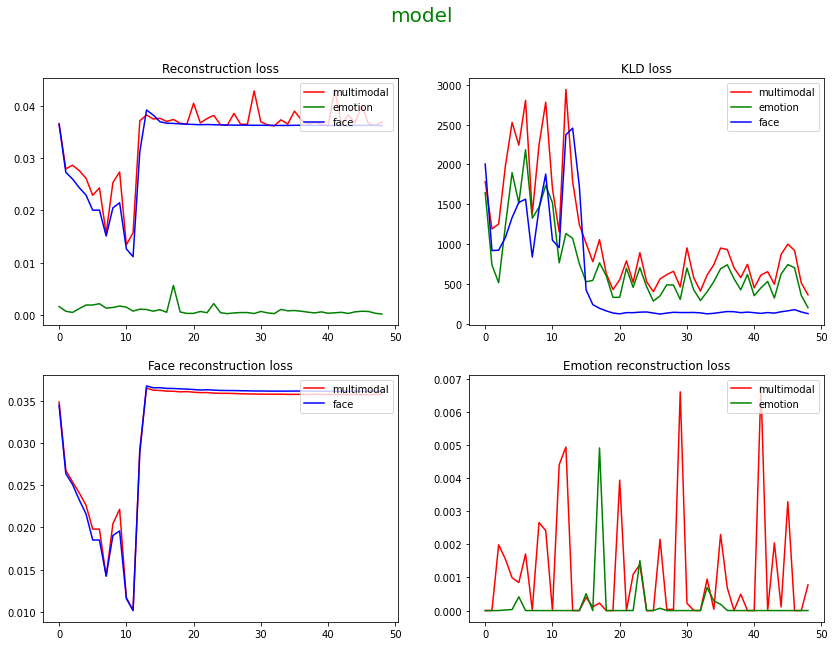

In [8]:
U.print_losses(training_losses, 'model', 1)

['surprised', 'happy', 'happy', 'neutral']
['calm', 'disgust', 'calm', 'surprised']


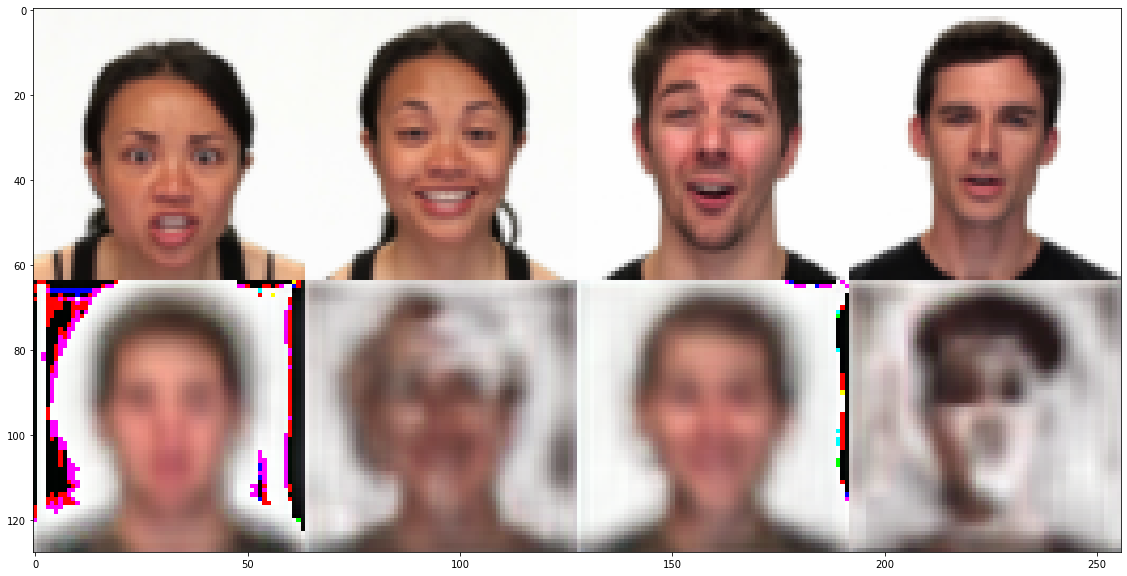

In [9]:
rec_image = U.test_batch(model, testset_loader, sample=True)

In [10]:
save_model = True

if save_model:
    PATH = "../trained_models/ravdess_mvae_CMx3_8k_long.save"
    torch.save({'rec_image' : rec_image,
                'model_args' : model_args,
                'training_loss' : training_losses,
                'train_args': train_args,
                'model_params' : model.state_dict()}, PATH)

In [11]:
print(training_losses['multimodal_loss'].kld_loss[-1])
print(training_losses['face_loss'].kld_loss[-1])
print(training_losses['emotion_loss'].kld_loss[-1])

366.688482030233
130.29157360765046
205.17027563078074


In [12]:
print(U.recon_and_classiffication_accuracy(model, testset_loader, sample=False))

100%|██████████████████████████████| 6/6 [00:20<00:00,  3.46s/it]

0.13333333333333333


In [13]:
print(U.classiffication_accuracy(model, testset_loader, sample=False))

100%|██████████████████████████████| 6/6 [00:20<00:00,  3.45s/it]

0.11805555555555555
